In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import plot_yearly
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from IPython.display import display
from geopy.geocoders import Nominatim
import datetime as dt


In [2]:
#place = input ("Enter Address :")
place = "408 brook pine trl, apex, nc"

In [3]:
geolocator = Nominatim(user_agent="Test")
location = geolocator.geocode(place)
location

Location(Brook Pine Trail, Town of Apex, Wake County, North Carolina, 27519-9443, United States, (35.7625474, -78.8912379, 0.0))

In [4]:
years = ['2016','2017','2018','2019']
df = []

lat, lon =  location.latitude, location.longitude
api_key = '5qyFRrBVjEZIGuR0WEcihqCEcg4LV8DbErgE6rze'
attributes = 'ghi'
leap_year = 'false'
interval = '30'
utc = 'false'
your_name = 'Anthony+N'
reason_for_use = 'testing'
your_affiliation = 'ECU'
your_email = 'natalea20@students.ecu.edu'
mailing_list = 'false'

for year in years:
    url = 'https://developer.nrel.gov/api/solar/nsrdb_psm3_download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes)
    df.append(pd.read_csv(url, skiprows=2))    

# Concatenate Multiple year data into one DataFrame
big_frame = pd.concat(df, ignore_index=True)


In [5]:
big_frame.head(5).append(big_frame.tail(5))

,Year,Month,Day,Hour,Minute,GHI
0,2016,1,1,0,0,0
1,2016,1,1,0,30,0
2,2016,1,1,1,0,0
3,2016,1,1,1,30,0
4,2016,1,1,2,0,0
70075,2019,12,31,21,30,0
70076,2019,12,31,22,0,0
70077,2019,12,31,22,30,0
70078,2019,12,31,23,0,0
70079,2019,12,31,23,30,0


In [6]:
#big_frame.sort_values(by=['Year','Month','Day','Hour','Minute'],ascending=True)

# Set the time index in the pandas dataframe:
#big_frame = big_frame.set_index(pd.date_range('1/1/{yr}'.format(yr=2017), freq=interval+'Min', periods=52560 ))
big_frame = big_frame.set_index(pd.date_range('1/1/{yr}'.format(yr=2016), freq=interval+'Min', periods=70080))

#big_frame.reset_index(inplace=True)

# take a look
big_frame.shape

(70080, 6)

In [7]:
# filtering data 
big_frame=big_frame[(big_frame["GHI"]!=0)]

In [8]:
big_frame.head(5).append(big_frame.tail(5))
big_frame.shape

(35412, 6)

In [9]:
big_frame.reset_index(inplace=True)

In [10]:
#New DF with just Index & GHI
prophet_frame = big_frame[['index','GHI']]
prophet_frame.head()

,index,GHI
0,2016-01-01 08:00:00,42
1,2016-01-01 08:30:00,97
2,2016-01-01 09:00:00,155
3,2016-01-01 09:30:00,210
4,2016-01-01 10:00:00,260


In [11]:
#Renaming columns to ds & y
prophet_frame = prophet_frame.rename(columns = {'index':'ds','GHI':'y'})
prophet_frame['ds']=pd.to_datetime(prophet_frame.ds)

In [12]:
prophet_frame.head(5).append(prophet_frame.tail(5))

,ds,y
0,2016-01-01 08:00:00,42
1,2016-01-01 08:30:00,97
2,2016-01-01 09:00:00,155
3,2016-01-01 09:30:00,210
4,2016-01-01 10:00:00,260
35407,2019-12-30 15:00:00,340
35408,2019-12-30 15:30:00,262
35409,2019-12-30 16:00:00,177
35410,2019-12-30 16:30:00,92
35411,2019-12-30 17:00:00,21


In [13]:
prophet_frame = prophet_frame.set_index(['ds'])

In [14]:
#Group by to get Daily Values
prophet_frame_new = prophet_frame.groupby(prophet_frame.index.date).sum()
prophet_frame_new.reset_index(inplace=True)
prophet_frame_new = prophet_frame_new.rename(columns = {'index':'ds'})
prophet_frame_new['ds']=pd.to_datetime(prophet_frame_new.ds)

#Drop rows with null values
prophet_frame_new.dropna() 

,ds,y
0,2016-01-01,2856
1,2016-01-02,6704
2,2016-01-03,5227
3,2016-01-04,3073
4,2016-01-05,6998
...,...,...
1455,2019-12-26,4210
1456,2019-12-27,5133
1457,2019-12-28,2777
1458,2019-12-29,3967


<AxesSubplot:xlabel='ds'>

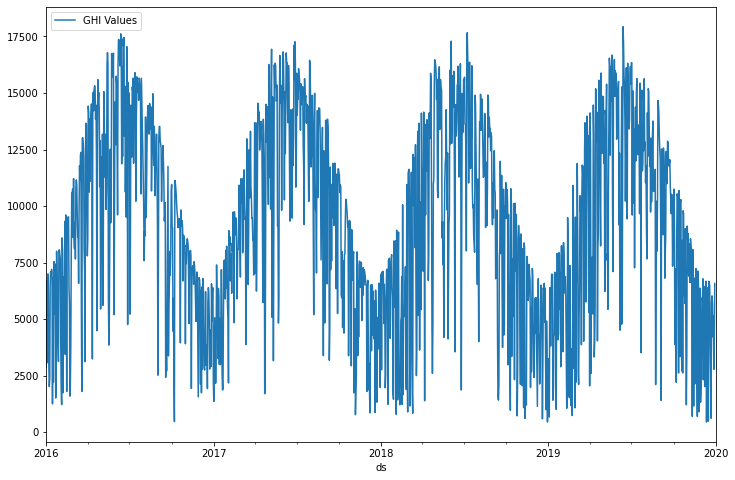

In [34]:
prophet_frame_new.plot(x='ds',y='y',figsize=(12,8),legend=True,label='GHI Values',xlim=('2016-01-01','2020-01-01'))
#prophet_frame_new.plot.line(x='ds',y='y')


In [16]:
train=prophet_frame_new[:1096]
test=prophet_frame_new[1096:]


#len(prophet_frame_new)
#train.plot()
#train.tail(5)
#test.head(5)
#train.plot(x='ds',y='y',figsize=(12,8),legend=True,label='GHI Values')
#train.plot(x='ds',y='y',figsize=(12,8),legend=True,label='GHI Values',xlim=('2016-01-01','2019-12-31'))


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(47.125, 0.5, 'GHI Values')

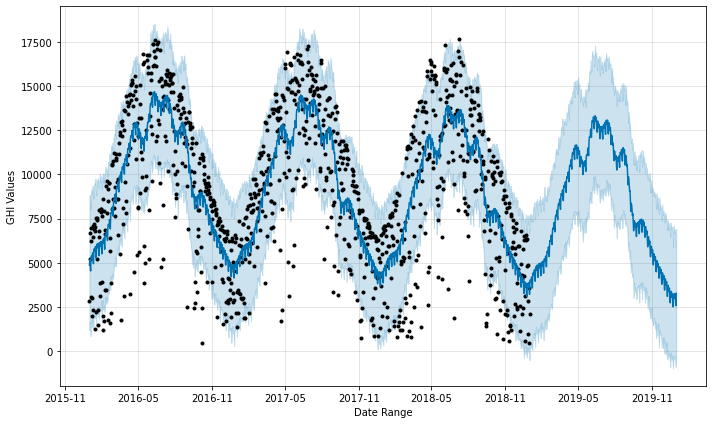

In [55]:
#Model 0
#Initialize Prophet Object
m=Prophet()
#Train the data
m.fit(train)
#Create Forecasting Time Periods
future=m.make_future_dataframe(periods=365,freq = 'D')
#Forecast using Training data
forecast=m.predict(future)

m.plot(forecast)


plt.xlabel("Date Range")
plt.ylabel("GHI Values")


#forecast.tail()

#ax=forecast.plot(x='ds',y='yhat_upper',legend=True,label='predictions',figsize=(12,8))
#test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('2019-01-01','2019-12-31'))

In [56]:
forecast.head(5).append(forecast.tail(5))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-01,9679.465557,1200.169464,8793.580523,9679.465557,9679.465557,-4799.035218,-4799.035218,-4799.035218,-18.484436,-18.484436,-18.484436,-4780.550782,-4780.550782,-4780.550782,0.0,0.0,0.0,4880.430339
1,2016-01-02,9679.210264,1663.450714,8856.177754,9679.210264,9679.210264,-4507.277364,-4507.277364,-4507.277364,226.902650,226.902650,226.902650,-4734.180013,-4734.180013,-4734.180013,0.0,0.0,0.0,5171.932900
2,2016-01-03,9678.954971,1256.607694,8487.646657,9678.954971,9678.954971,-4847.190334,-4847.190334,-4847.190334,-163.579043,-163.579043,-163.579043,-4683.611291,-4683.611291,-4683.611291,0.0,0.0,0.0,4831.764637
3,2016-01-04,9678.699678,877.531260,8011.351030,9678.699678,9678.699678,-5134.305729,-5134.305729,-5134.305729,-504.780289,-504.780289,-504.780289,-4629.525440,-4629.525440,-4629.525440,0.0,0.0,0.0,4544.393949
4,2016-01-05,9678.444385,1629.779982,8954.487304,9678.444385,9678.444385,-4420.530295,-4420.530295,-4420.530295,152.122338,152.122338,152.122338,-4572.652633,-4572.652633,-4572.652633,0.0,0.0,0.0,5257.914090
1456,2019-12-27,7956.046765,-451.351220,6698.014934,7906.212127,8008.358781,-4949.193815,-4949.193815,-4949.193815,-18.484436,-18.484436,-18.484436,-4930.709379,-4930.709379,-4930.709379,0.0,0.0,0.0,3006.852950
1457,2019-12-28,7954.420450,-297.516963,6791.015233,7904.324046,8006.889688,-4686.013457,-4686.013457,-4686.013457,226.902650,226.902650,226.902650,-4912.916106,-4912.916106,-4912.916106,0.0,0.0,0.0,3268.406993
1458,2019-12-29,7952.794135,-804.275500,6897.010073,7902.475541,8005.420595,-5052.274684,-5052.274684,-5052.274684,-163.579043,-163.579043,-163.579043,-4888.695641,-4888.695641,-4888.695641,0.0,0.0,0.0,2900.519451
1459,2019-12-30,7951.167820,-891.329015,5922.458844,7900.449353,8003.951502,-5363.086376,-5363.086376,-5363.086376,-504.780289,-504.780289,-504.780289,-4858.306087,-4858.306087,-4858.306087,0.0,0.0,0.0,2588.081444
1460,2019-12-31,7949.541505,-278.212915,6927.118339,7898.378394,8002.653086,-4669.984102,-4669.984102,-4669.984102,152.122338,152.122338,152.122338,-4822.106440,-4822.106440,-4822.106440,0.0,0.0,0.0,3279.557403


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='ds'>

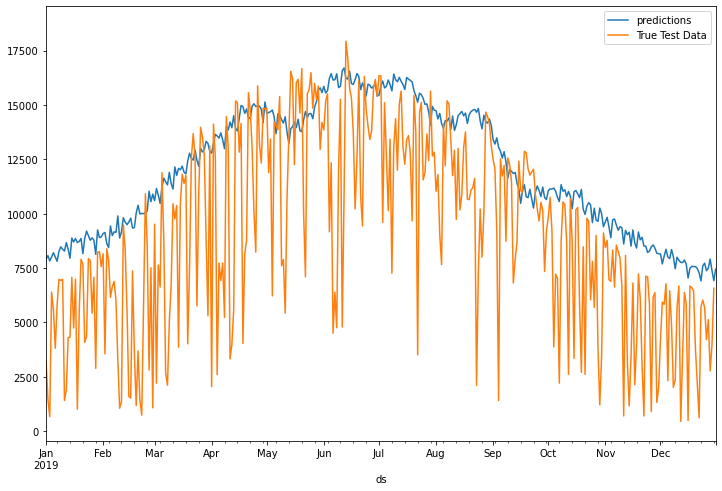

In [63]:
#Model 1
m1=Prophet(seasonality_mode='multiplicative')
m1.fit(train)

future=m1.make_future_dataframe(periods=365,freq = 'D') 
forecast=m1.predict(future)
#forecast.tail()


ax=forecast.plot(x='ds',y='yhat_upper',legend=True,label='predictions',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('2019-01-01','2019-12-31'))

In [59]:
dfprint = forecast[["ds", "trend","yhat_lower", "yhat_upper", "yhat"]]
dfprint.head(5).append(dfprint.tail(5))

,ds,trend,yhat_lower,yhat_upper,yhat
0,2016-01-01,9677.688070,839.673584,8607.091248,4672.024092
1,2016-01-02,9677.351039,1127.610846,8564.283123,4973.400667
2,2016-01-03,9677.014008,953.464865,8415.532079,4639.580318
3,2016-01-04,9676.676977,693.913458,7904.942798,4347.886353
4,2016-01-05,9676.339947,1472.217566,8619.386772,5099.876166
1456,2019-12-27,8072.055806,41.360700,7589.103606,3724.159733
1457,2019-12-28,8070.592042,544.333534,7637.732699,3949.853848
1458,2019-12-29,8069.128279,59.887745,7171.053794,3648.205305
1459,2019-12-30,8067.664516,-327.633557,7101.428261,3384.502691
1460,2019-12-31,8066.200752,391.036084,7554.643659,3993.933041


<AxesSubplot:xlabel='ds'>

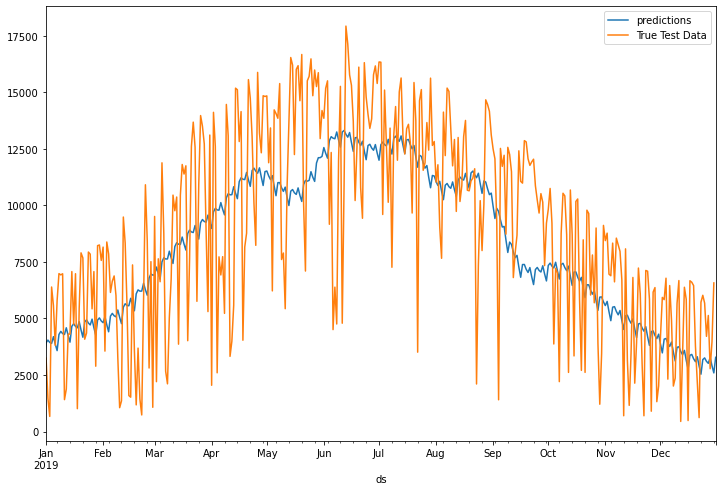

In [19]:
#Model 2
m2 = Prophet(weekly_seasonality=True,daily_seasonality=True,yearly_seasonality=True)
m2.fit(train)

future=m2.make_future_dataframe(periods=365,freq = 'D') 
forecast=m2.predict(future)


ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('2019-01-01','2019-12-31'))

<AxesSubplot:xlabel='ds'>

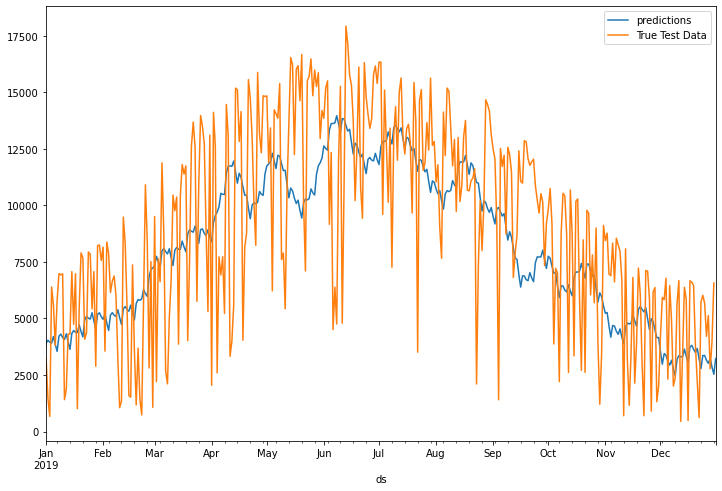

In [24]:
m3 = Prophet(weekly_seasonality=True,daily_seasonality=True,yearly_seasonality=20)
m3.add_seasonality(name='daily', period=365.25, fourier_order=5, prior_scale=0.02)

m3.fit(train)

future=m3.make_future_dataframe(periods=365,freq = 'D') 
forecast=m3.predict(future)


ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('2019-01-01','2019-12-31'))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='ds'>

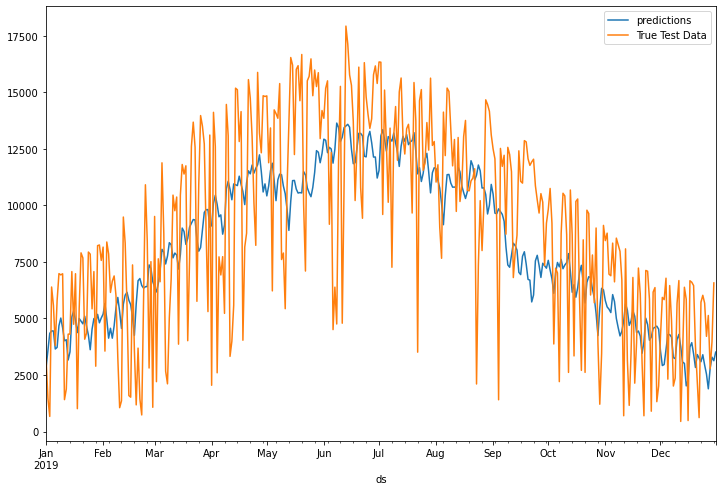

In [25]:
m4 = Prophet(weekly_seasonality=True)
m4.add_seasonality(name='monthly', period=12, fourier_order=5)

m4.fit(train)

future=m4.make_future_dataframe(periods=365,freq = 'D') 
#future=m4.make_future_dataframe(periods=12,freq='MS') 
forecast=m4.predict(future)


ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('2019-01-01','2019-12-31'))